In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.python import tf2
from keras import distribute

In [2]:
train= pd.read_csv('Price_train.csv')
test= pd.read_csv('Price_test.csv')

In [3]:
train.head()

,Date,Open,High,Low,Close,Volume
0,01/03/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,01/04/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,01/05/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,01/06/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,01/09/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
train.describe

<bound method NDFrame.describe of             Date    Open    High     Low   Close      Volume
0     01/03/2012  325.25  332.83  324.97  663.59   7,380,500
1     01/04/2012  331.27  333.87  329.08  666.45   5,749,400
2     01/05/2012  329.83  330.75  326.89  657.21   6,590,300
3     01/06/2012  328.34  328.77  323.68  648.24   5,405,900
4     01/09/2012  322.04  322.29  309.46  620.76  11,688,800
...          ...     ...     ...     ...     ...         ...
1253  12/23/2016  790.90  792.74  787.28  789.91     623,400
1254  12/27/2016  790.68  797.86  787.66  791.55     789,100
1255  12/28/2016  793.70  794.23  783.20  785.05   1,153,800
1256  12/29/2016  783.33  785.93  778.92  782.79     744,300
1257  12/30/2016  782.75  782.78  770.41  771.82   1,770,000

[1258 rows x 6 columns]>

In [5]:
test.tail()

,Date,Open,High,Low,Close,Volume
15,1/25/2017,829.62,835.77,825.06,835.67,"1,494,500"
16,1/26/2017,837.81,838.00,827.01,832.15,"2,973,900"
17,1/27/2017,834.71,841.95,820.44,823.31,"2,965,800"
18,1/30/2017,814.66,815.84,799.80,802.32,"3,246,600"
19,1/31/2017,796.86,801.25,790.52,796.79,"2,160,600"


In [7]:
test.describe

<bound method NDFrame.describe of           Date    Open    High     Low   Close     Volume
0   01/03/2017  778.81  789.63  775.80  786.14  1,657,300
1   01/04/2017  788.36  791.34  783.16  786.90  1,073,000
2   01/05/2017  786.08  794.48  785.02  794.02  1,335,200
3   01/06/2017  795.26  807.90  792.20  806.15  1,640,200
4   01/09/2017  806.40  809.97  802.83  806.65  1,272,400
5   01/10/2017  807.86  809.13  803.51  804.79  1,176,800
6   01/11/2017  805.00  808.15  801.37  807.91  1,065,900
7   01/12/2017  807.14  807.39  799.17  806.36  1,353,100
8    1/13/2017  807.48  811.22  806.69  807.88  1,099,200
9    1/17/2017  807.08  807.14  800.37  804.61  1,362,100
10   1/18/2017  805.81  806.21  800.99  806.07  1,294,400
11   1/19/2017  805.12  809.48  801.80  802.17    919,300
12   1/20/2017  806.91  806.91  801.69  805.02  1,670,000
13   1/23/2017  807.25  820.87  803.74  819.31  1,963,600
14   1/24/2017  822.30  825.90  817.82  823.87  1,474,000
15   1/25/2017  829.62  835.77  825.06

In [8]:
train_open= train.iloc[:, 1:2].values 
#

In [9]:
train_open


array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [10]:
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
train_open_scaled= ss.fit_transform(train_open)

In [11]:
train_open_scaled[60]

array([0.08627874])

In [12]:
xtrain=[]
ytrain=[]
for i in range(60,len(train_open_scaled)):
 xtrain.append(train_open_scaled[i-60:i,0])
 ytrain.append(train_open_scaled[i,0])
xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [13]:
xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))

In [15]:
xtrain.shape

(1198, 60, 1)

In [19]:
#initialising the model
model= Sequential()
#First Input layer and LSTM layer with 0.2% dropout
model.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1
],1)))
model.add(Dropout(0.2))
# Where:
# return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
# Second LSTM layer with 0.2% dropout
model.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
model.add(Dropout(0.2))
#Third LSTM layer with 0.2% dropout
model.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
model.add(Dropout(0.2))
#Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
model.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
model.add(Dropout(0.2))
#Output layer , we wont pass any activation as its continous value model
model.add(Dense(units=1))
#Compiling the network
model.compile(optimizer='adam',loss='mean_squared_error')
#fitting the network
model.fit(xtrain,ytrain,batch_size=30,epochs=200)

Epoch 1/200
40/40 [==============================] - 18s 144ms/step - loss: 0.0497
Epoch 2/200
40/40 [==============================] - 6s 144ms/step - loss: 0.0054
Epoch 3/200
40/40 [==============================] - 6s 144ms/step - loss: 0.0054
Epoch 4/200
40/40 [==============================] - 6s 140ms/step - loss: 0.0053
Epoch 5/200
40/40 [==============================] - 5s 115ms/step - loss: 0.0046
Epoch 6/200
40/40 [==============================] - 5s 130ms/step - loss: 0.0046
Epoch 7/200
40/40 [==============================] - 6s 154ms/step - loss: 0.0054
Epoch 8/200
40/40 [==============================] - 6s 149ms/step - loss: 0.0048
Epoch 9/200
40/40 [==============================] - 6s 146ms/step - loss: 0.0050
Epoch 10/200
40/40 [==============================] - 6s 147ms/step - loss: 0.0045
Epoch 11/200
40/40 [==============================] - 6s 146ms/step - loss: 0.0048
Epoch 12/200
40/40 [==============================] - 5s 137ms/step - loss: 0.0037
Epoch 13/200

40/40 [==============================] - 6s 155ms/step - loss: 0.0014
Epoch 100/200
40/40 [==============================] - 6s 153ms/step - loss: 0.0014
Epoch 101/200
40/40 [==============================] - 6s 153ms/step - loss: 0.0015
Epoch 102/200
40/40 [==============================] - 6s 152ms/step - loss: 0.0016
Epoch 103/200
40/40 [==============================] - 6s 154ms/step - loss: 0.0014
Epoch 104/200
40/40 [==============================] - 6s 154ms/step - loss: 0.0013
Epoch 105/200
40/40 [==============================] - 6s 155ms/step - loss: 0.0014
Epoch 106/200
40/40 [==============================] - 6s 152ms/step - loss: 0.0012
Epoch 107/200
40/40 [==============================] - 6s 154ms/step - loss: 0.0012
Epoch 108/200
40/40 [==============================] - 6s 137ms/step - loss: 0.0013
Epoch 109/200
40/40 [==============================] - 6s 154ms/step - loss: 0.0014
Epoch 110/200
40/40 [==============================] - 6s 154ms/step - loss: 0.0015
Epoch 

40/40 [==============================] - 7s 167ms/step - loss: 9.4963e-04
Epoch 197/200
40/40 [==============================] - 6s 158ms/step - loss: 0.0011
Epoch 198/200
40/40 [==============================] - 6s 155ms/step - loss: 9.1626e-04
Epoch 199/200
40/40 [==============================] - 5583s 143s/step - loss: 0.0011
Epoch 200/200
40/40 [==============================] - 4s 107ms/step - loss: 0.0010


In [ ]:
# wantds explanation for this code in the assessment

In [20]:
test_open= test.iloc[:, 1:2].values #taking open price
total= pd.concat([train['Open'],test['Open']],axis=0) # Concating train and test and then will take last 60 train point
test_input = total[len(total)-len(test)-60:].values
test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
test_input= ss.transform(test_input)


In [21]:
xtest= []
for i in range(60,80):
 xtest.append(test_input[i-60:i,0]) 

In [22]:
xtest= np.array(xtest)


In [23]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= model.predict(xtest)


In [24]:
predicted_value= ss.inverse_transform(predicted_value)

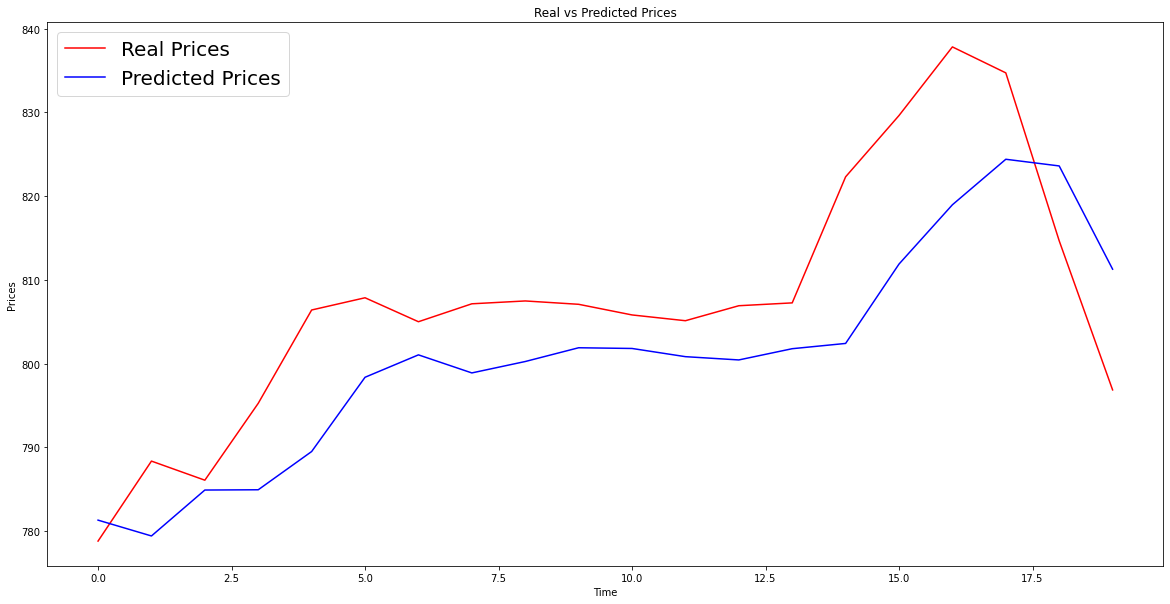

In [25]:
plt.figure(figsize=(20,10))
plt.plot(test_open,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)